In [1]:
import tensorflow as tf
from IPython.display import clear_output
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import datasets, layers, models
from matplotlib import pyplot as plt
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gpu = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())

Number of GPUs : 1
Tensorflow GPU : True


In [221]:
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

In [141]:
import cv2
from tqdm import tqdm
data_dir = "C:/Users/iaren/Videos/Captures/Ultradata"
data_dir_train = "C:/Users/iaren/Videos/Captures/Ultradata/train"
data_dir_test = "C:/Users/iaren/Videos/Captures/Ultradata/test"
data_dir, data_dir_train, data_dir_test = pathlib.Path(data_dir), pathlib.Path(data_dir_train), pathlib.Path(data_dir_test) 
image_count = len(list(data_dir_train.glob('*.jpg')))#  + len(list(data_dir_test.glob('*.jpg')))
print(image_count)

292


In [142]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

(256, 512, 3)


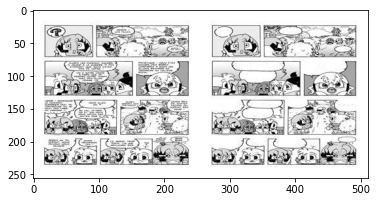

In [143]:
PATH = data_dir.parent/data_dir_train

list(PATH.parent.iterdir())

sample_image = tf.io.read_file(str(PATH / '0 (1).jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)
plt.figure()
plt.imshow(sample_image)

In [144]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

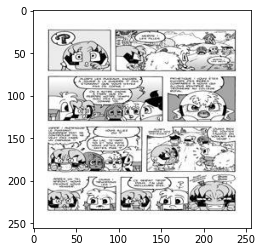

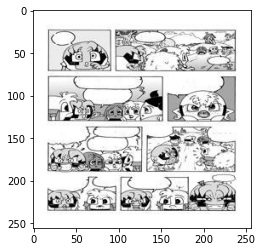

In [145]:
inp, re = load(str(PATH / '0 (1).jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [146]:
# The facade training set consist of 400 images
BUFFER_SIZE = 292
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

IMG_WIDTH = 256
IMG_HEIGHT = 256
# for i in range (1, 99, 1):
#     sample_image = tf.io.read_file(str(PATH / f'0 ({i}).jpg'))
#     sample_image = tf.io.decode_jpeg(sample_image)
#     x, y, z = sample_image.shape
#     width.append(x)
#     height.append(y)
print(IMG_WIDTH)
print(IMG_HEIGHT)

256
256


In [147]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [148]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to ...
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

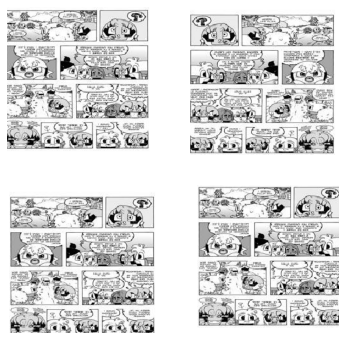

In [149]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [150]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [151]:

train_dataset = tf.data.Dataset.list_files(str(data_dir_train/'*'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE) 


try:
  test_dataset = tf.data.Dataset.list_files(str(data_dir/'test/*'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(data_dir/'test/*'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE) 
print(type(test_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [235]:
print(list(train_dataset.as_numpy_iterator()))

In [30]:
print(test_dataset)

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>


In [61]:
fileList=[]
fl=[]
for dirname, _, filenames in os.walk('C:/Users/iaren/PycharmProjects/TextRemoveNN/ultaa/train'):
    for filename in filenames:
        fileList.append(os.path.join(dirname, filename))
for i in fileList:
    if i.endswith('.jpg'):
        fl.append(i)
fileList=np.array(fl)

In [155]:
from PIL import Image
fl=[]
for filename in fileList:
    
    try:
      img = Image.open(filename)# open the image file
      img.verify() # verify that it is, in fact an image
      fl.append(filename)
    except Exception:
        print("Bad File",filename)
fileList=np.array(fl)
np.random.shuffle(fileList)

NameError: name 'fileList' is not defined

In [63]:
batch = 1
def decode_img(x):
    x=tf.io.read_file(x)
    x=tf.image.decode_jpeg(x,channels=3)
    x=tf.image.resize(x,(256,256))
    return x

def rgb_to_gs(x):
    gs = tf.image.rgb_to_grayscale(x)
    gs=tf.math.divide(gs,255)
    return gs


def create_dataset(filename_list):
    df=tf.data.Dataset.from_tensor_slices(filename_list)
    im=df.map(decode_img)
    gs=im.map(rgb_to_gs)
    df=tf.data.Dataset.zip((gs,im))
    df=df.batch(batch)
    df=df.prefetch(tf.data.experimental.AUTOTUNE)
    return df
#These are the actual objects representing the input pipeline for Training and Testing
train_df=create_dataset(fileList[:int(len(fileList)*0.8)])
test_df=create_dataset(fileList[int(len(fileList)*0.8):])

In [64]:
print(type(train_df))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


# Model

In [152]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
# from kaggle nerve segmentation competition 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def unet():
    input = Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = "same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = "same")(x)
    x1 = tf.keras.layers.BatchNormalization()(x)
    print(x1.shape)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x1)
    
    x = tf.keras.layers.Conv2D(128, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation = 'relu',  padding = "same")(x)
    x2 = tf.keras.layers.BatchNormalization()(x)
    print(x2.shape)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x2)
    
    x = tf.keras.layers.Conv2D(256, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation = 'relu',  padding = "same")(x)
    x3 = tf.keras.layers.BatchNormalization()(x)
    print(x3.shape)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x3)

    x = tf.keras.layers.Conv2D(512, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, 3, activation = 'relu',  padding = "same")(x)
    x4 = tf.keras.layers.BatchNormalization()(x)
    print(x4.shape)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x4)
    
    x = tf.keras.layers.Conv2DTranspose(512, 2, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Resizing(32, 32)(x)
    print(x.shape)
    x = tf.keras.layers.Concatenate(axis=1)([x, x4])
    x = tf.keras.layers.Resizing(64, 64)(x)
    x = tf.keras.layers.Conv2D(512, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, 2, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    print(x.shape)
    x = tf.keras.layers.Concatenate(axis=1)([x, x3])
    x = tf.keras.layers.Resizing(128, 128)(x)
    x = tf.keras.layers.Conv2D(256, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, 2, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    print(x.shape)
    x = tf.keras.layers.Concatenate()([x, x2])
    x = tf.keras.layers.Resizing(256, 256)(x)
    x = tf.keras.layers.Conv2D(128, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 2, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    print(x.shape)
    x = tf.keras.layers.Concatenate()([x, x1])
    x = tf.keras.layers.Resizing(256, 256)(x)
    x = tf.keras.layers.Conv2D(64, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation = 'relu',  padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(3, 3, padding = "same")(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    model = Model(inputs=[input], outputs=[x])

    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

    return model
    

In [153]:
model = unet()

(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)


In [130]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 256, 256, 64) 1792        input_56[0][0]                   
__________________________________________________________________________________________________
batch_normalization_566 (BatchN (None, 256, 256, 64) 256         conv2d_501[0][0]                 
__________________________________________________________________________________________________
conv2d_502 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_566[0][0]    
____________________________________________________________________________________________

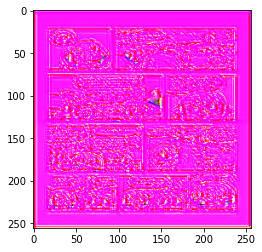

In [154]:
mod_output = model(inp[tf.newaxis, ...], training=False)
plt.imshow(mod_output[0, ...])

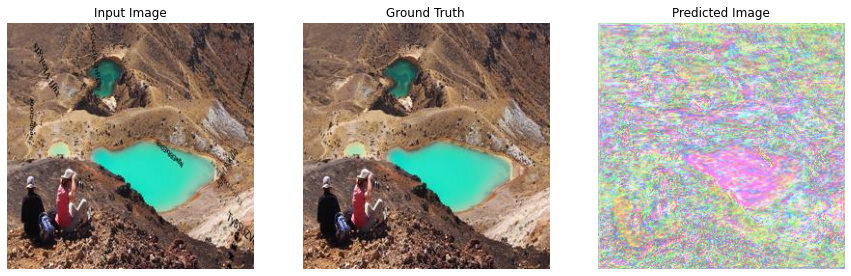

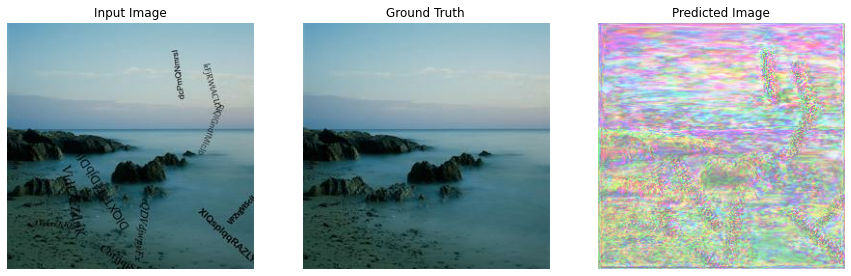

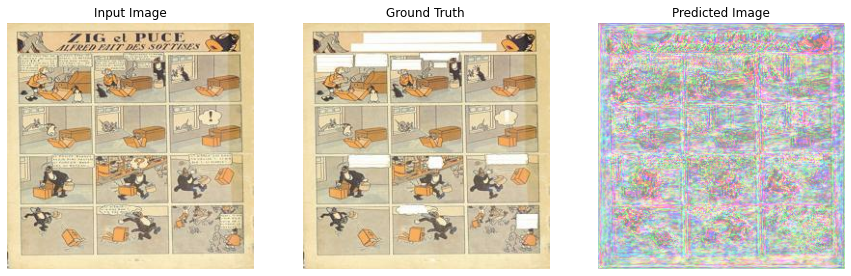

In [155]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for inp, tar in test_dataset.take(3):
  generate_images(model, inp, tar)

In [161]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.huber,
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=35, batch_size=4, 
                    validation_data=test_dataset)

Epoch 1/35
292/292 [==============================] - 117s 380ms/step - loss: 0.0759 - accuracy: 0.5610 - val_loss: 0.0966 - val_accuracy: 0.6277
Epoch 2/35
292/292 [==============================] - 107s 362ms/step - loss: 0.0754 - accuracy: 0.5521 - val_loss: 0.0960 - val_accuracy: 0.6072
Epoch 3/35
292/292 [==============================] - 107s 362ms/step - loss: 0.0764 - accuracy: 0.5555 - val_loss: 0.0960 - val_accuracy: 0.6385
Epoch 4/35
292/292 [==============================] - 107s 362ms/step - loss: 0.0754 - accuracy: 0.5652 - val_loss: 0.0948 - val_accuracy: 0.6122
Epoch 5/35
292/292 [==============================] - 107s 363ms/step - loss: 0.0749 - accuracy: 0.5641 - val_loss: 0.0945 - val_accuracy: 0.6215
Epoch 6/35
292/292 [==============================] - 107s 363ms/step - loss: 0.0744 - accuracy: 0.5659 - val_loss: 0.0965 - val_accuracy: 0.5862
Epoch 7/35
292/292 [==============================] - 107s 363ms/step - loss: 0.0741 - accuracy: 0.5632 - val_loss: 0.0974 -

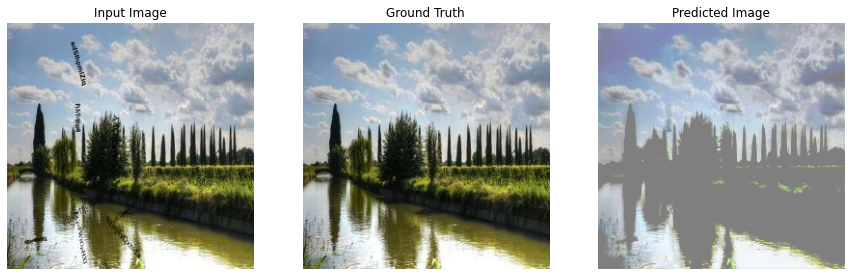

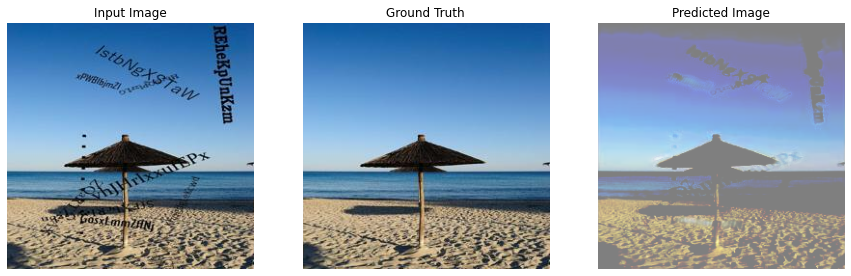

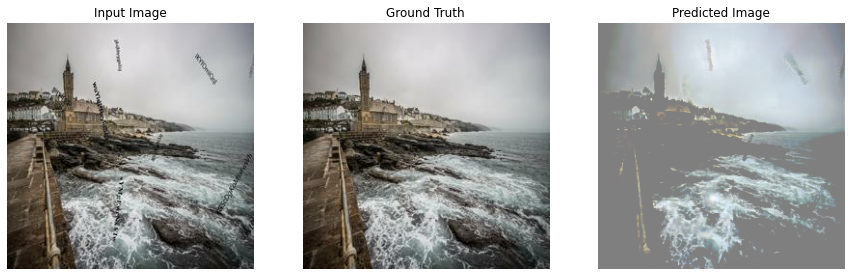

In [164]:


for inp, tar in test_dataset.take(3):
  generate_images(model, inp, tar)

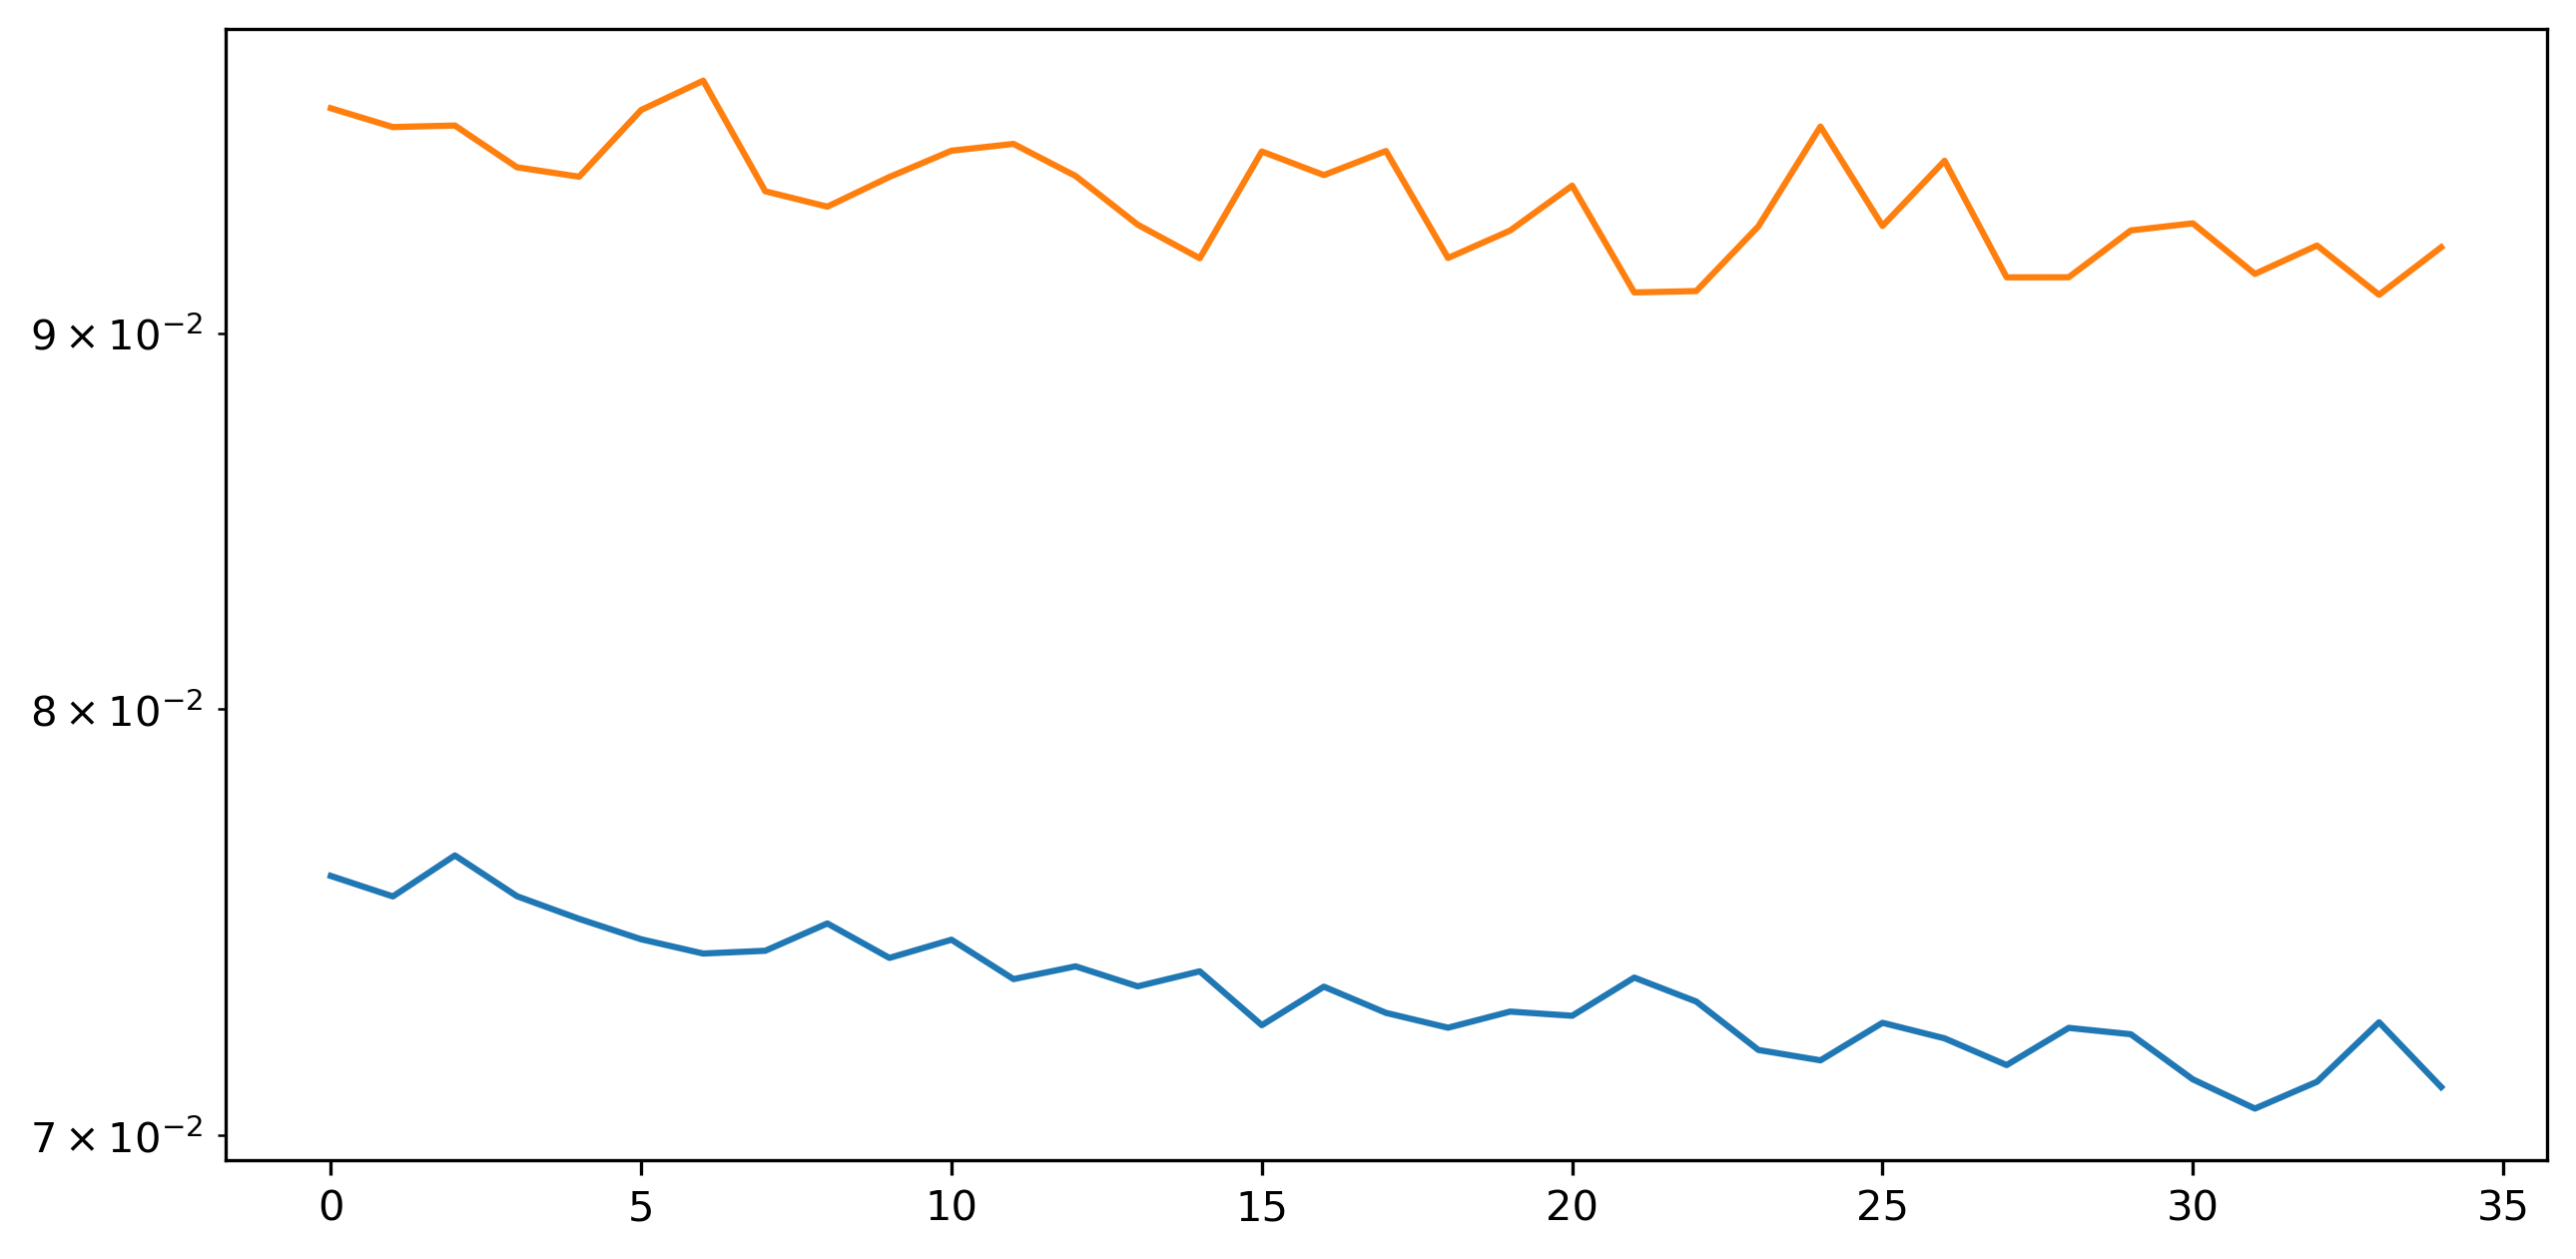

In [165]:
plt.figure(figsize=(10, 5), dpi=300)
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

In [166]:
model.evaluate(test_dataset)

192/192 [==============================] - 17s 86ms/step - loss: 0.0922 - accuracy: 0.6475


[0.09222617745399475, 0.6475276350975037]

In [137]:
model.save("first_unet.h5")

In [252]:
from tensorflow.keras.models import Model, load_model
model = load_model("first_unet.h5")